In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit import RDPaths

import dgl
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from dgl import model_zoo

from dgl.data.chem.utils import mol_to_complete_graph, mol_to_bigraph

from dgl.data.chem.utils import atom_type_one_hot
from dgl.data.chem.utils import atom_degree_one_hot
from dgl.data.chem.utils import atom_formal_charge
from dgl.data.chem.utils import atom_num_radical_electrons
from dgl.data.chem.utils import atom_hybridization_one_hot
from dgl.data.chem.utils import atom_total_num_H_one_hot
from dgl.data.chem.utils import one_hot_encoding
from dgl.data.chem import CanonicalAtomFeaturizer
from dgl.data.chem import CanonicalBondFeaturizer
from dgl.data.chem import ConcatFeaturizer
from dgl.data.chem import BaseAtomFeaturizer
from dgl.data.chem import BaseBondFeaturizer

from dgl.data.chem import one_hot_encoding
from dgl.data.utils import split_dataset

from functools import partial
from sklearn.metrics import roc_auc_score

ModuleNotFoundError: No module named 'dgl'

In [2]:
torch.cuda.is_available()

True

In [3]:
def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]
    
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 3-tuples or 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally
        a binary mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : BatchedDGLGraph
        Batched DGLGraphs
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels. If binary masks are not
        provided, return a tensor with ones.
    """
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
    
    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks



In [4]:
atom_featurizer = BaseAtomFeaturizer(
                 {'hv': ConcatFeaturizer([
                  partial(atom_type_one_hot, allowable_set=[
                          'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
                    encode_unknown=True),
                  partial(atom_degree_one_hot, allowable_set=list(range(6))),
                  atom_formal_charge, atom_num_radical_electrons,
                  partial(atom_hybridization_one_hot, encode_unknown=True),
                  lambda atom: [0], # A placeholder for aromatic information,
                    atom_total_num_H_one_hot, chirality
                 ],
                )})
bond_featurizer = BaseBondFeaturizer({
                                     'he': lambda bond: [0 for _ in range(10)]
    })

In [5]:
train=os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.train.sdf')
test=os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.test.sdf')

In [6]:
train_mols = Chem.SDMolSupplier(train)
train_smi =[Chem.MolToSmiles(m) for m in train_mols]
train_sol = torch.tensor([float(mol.GetProp('SOL')) for mol in train_mols]).reshape(-1,1)

test_mols =  Chem.SDMolSupplier(test)
test_smi = [Chem.MolToSmiles(m) for m in test_mols]
test_sol = torch.tensor([float(mol.GetProp('SOL')) for mol in test_mols]).reshape(-1,1)

In [7]:
train_graph =[mol_to_bigraph(mol,
                           atom_featurizer=atom_featurizer, 
                           bond_featurizer=bond_featurizer) for mol in train_mols]

test_graph =[mol_to_bigraph(mol,
                           atom_featurizer=atom_featurizer, 
                           bond_featurizer=bond_featurizer) for mol in test_mols]

In [8]:
def run_a_train_epoch(n_epochs, epoch, model, data_loader,loss_criterion, optimizer):
    model.train()
    total_loss = 0
    losses = []
    
    for batch_id, batch_data in enumerate(data_loader):
        batch_data
        smiles, bg, labels, masks = batch_data
        if torch.cuda.is_available():
            bg.to(torch.device('cuda:0'))
            labels = labels.to('cuda:0')
            masks = masks.to('cuda:0')
        
        prediction = model(bg, bg.ndata['hv'], bg.edata['he'])
        loss = (loss_criterion(prediction, labels)*(masks != 0).float()).mean()
        #loss = loss_criterion(prediction, labels)
        #print(loss.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.item())
        
    #total_score = np.mean(train_meter.compute_metric('rmse'))
    total_score = np.mean(losses)
    print('epoch {:d}/{:d}, training {:.4f}'.format( epoch + 1, n_epochs,  total_score))
    return total_score

In [9]:
model = model_zoo.chem.AttentiveFP(node_feat_size=39,
                                  edge_feat_size=10,
                                  num_layers=2,
                                  num_timesteps=2,
                                  graph_feat_size=200,
                                  output_size=1,
                                  dropout=0.2)
model = model.to('cuda:0')

In [10]:
train_loader = DataLoader(dataset=list(zip(train_smi, train_graph, train_sol)), batch_size=128, collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=list(zip(test_smi, test_graph, test_sol)), batch_size=128, collate_fn=collate_molgraphs)

In [11]:
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=10 ** (-2.5), weight_decay=10 ** (-5.0),)
n_epochs = 100
epochs = []
scores = []
for e in range(n_epochs):
    score = run_a_train_epoch(n_epochs, e, model, train_loader, loss_fn, optimizer)
    epochs.append(e)
    scores.append(score)

epoch 1/100, training 10.3861
epoch 2/100, training 4.5270
epoch 3/100, training 3.9297
epoch 4/100, training 3.2830
epoch 5/100, training 3.1945
epoch 6/100, training 2.5470
epoch 7/100, training 2.4009
epoch 8/100, training 1.8935
epoch 9/100, training 1.1095
epoch 10/100, training 0.8527
epoch 11/100, training 1.2657
epoch 12/100, training 1.7431
epoch 13/100, training 1.1584
epoch 14/100, training 1.0794
epoch 15/100, training 0.9055
epoch 16/100, training 0.6647
epoch 17/100, training 0.6319
epoch 18/100, training 0.5721
epoch 19/100, training 0.5546
epoch 20/100, training 0.5408
epoch 21/100, training 0.5167
epoch 22/100, training 0.5643
epoch 23/100, training 0.5769
epoch 24/100, training 0.4929
epoch 25/100, training 0.4407
epoch 26/100, training 0.4709
epoch 27/100, training 0.5146
epoch 28/100, training 0.6413
epoch 29/100, training 0.7296
epoch 30/100, training 0.5777
epoch 31/100, training 0.6066
epoch 32/100, training 0.6477
epoch 33/100, training 0.4670
epoch 34/100, trai

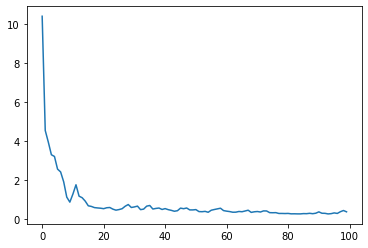

In [12]:
plt.plot(epochs, scores)

In [13]:
model.eval()

AttentiveFP(
  (init_context): GetContext(
    (project_node): Sequential(
      (0): Linear(in_features=39, out_features=200, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (project_edge1): Sequential(
      (0): Linear(in_features=49, out_features=200, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (project_edge2): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=400, out_features=1, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (attentive_gru): AttentiveGRU1(
      (edge_transform): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=200, out_features=200, bias=True)
      )
      (gru): GRUCell(200, 200)
    )
  )
  (gnn_layers): ModuleList(
    (0): GNNLayer(
      (project_edge): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=400, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive

In [14]:
all_pred = []
for test_data in test_loader:
    smi_lst, bg, labels, masks = test_data
    if torch.cuda.is_available():
            bg.to(torch.device('cuda:0'))
            labels = labels.to('cuda:0')
            masks = masks.to('cuda:0')
    pred = model(bg, bg.ndata['hv'], bg.edata['he'])
    all_pred.append(pred.data.cpu().numpy())

In [15]:
res = np.vstack(all_pred)

In [16]:
res.shape

(257, 1)

In [17]:
test_sol.numpy().shape

(257, 1)

Text(0, 0.5, 'exp')

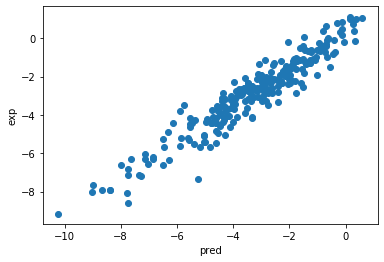

In [18]:
plt.clf()
plt.scatter(res, test_sol)
plt.xlabel('pred')
plt.ylabel('exp')

In [19]:
from sklearn.metrics import r2_score

In [20]:
print(r2_score(test_sol, res))

0.8605614290390137


In [21]:
from sklearn.ensemble import RandomForestRegressor
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

In [22]:
train_fp = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in train_mols]
test_fp = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in test_mols]

In [23]:
rfr = RandomForestRegressor()

In [24]:
rfr.fit(train_fp, train_sol)

/home/takayuki/anaconda3/envs/chemo37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/takayuki/anaconda3/envs/chemo37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [25]:
rfr_pred = rfr.predict(test_fp)

In [26]:
r2_score(test_sol, rfr_pred)

0.6881015769353733

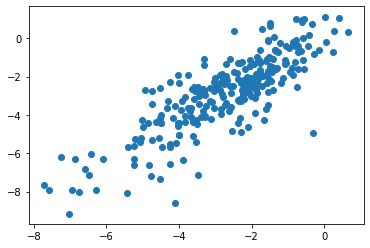

In [27]:
plt.clf()
plt.scatter(rfr_pred, test_sol)

In [28]:
import copy
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from IPython.display import display
import matplotlib
import matplotlib.cm as cm


In [29]:
def drawmol(idx, dataset, timestep):
    smiles, graph, _ = dataset[idx]
    print(smiles)
    bg = dgl.batch([graph])
    atom_feats, bond_feats = bg.ndata['hv'], bg.edata['he']
    if torch.cuda.is_available():
        print('use cuda')
        bg.to(torch.device('cuda:0'))
        atom_feats = atom_feats.to('cuda:0')
        bond_feats = bond_feats.to('cuda:0')
    
    _, atom_weights = model(bg, atom_feats, bond_feats, get_node_weight=True)
    assert timestep < len(atom_weights), 'Unexpected id for the readout round'
    atom_weights = atom_weights[timestep]
    min_value = torch.min(atom_weights)
    max_value = torch.max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(bg.number_of_nodes())}

    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(bg.number_of_nodes()),
                             highlightBonds=[],
                             highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    if torch.cuda.is_available():
        atom_weights = atom_weights.to('cpu')
    return (Chem.MolFromSmiles(smiles), atom_weights.data.numpy(), svg)

In [30]:
target = test_loader.dataset


In [31]:
res = drawmol(0, target, 0)

CCC(C)CC
use cuda


CCC(C)CC
use cuda


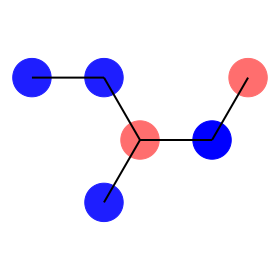

CC(C)CC(C)C
use cuda


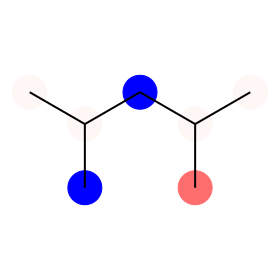

C=CCCC
use cuda


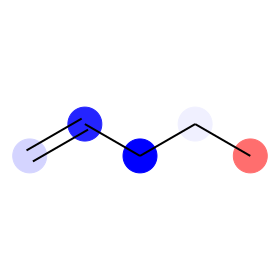

C1=CCCCC1
use cuda


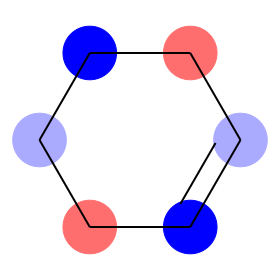

C=CCC=C
use cuda


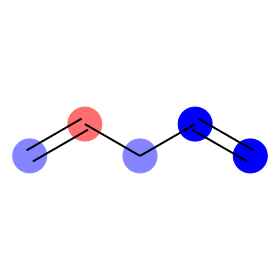

C1=CC=CCC=C1
use cuda


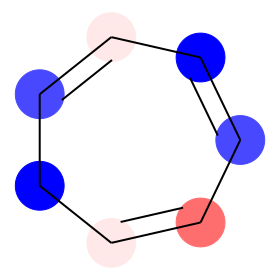

C#CCCCCCC
use cuda


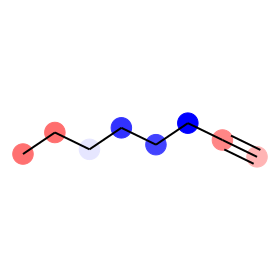

CCc1ccccc1
use cuda


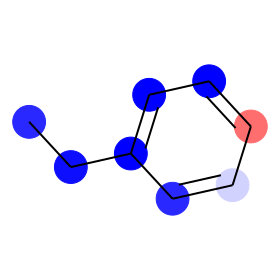

Cc1cc(C)cc(C)c1
use cuda


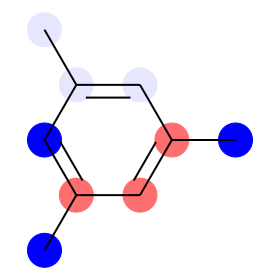

c1ccc2c(c1)CCC2
use cuda


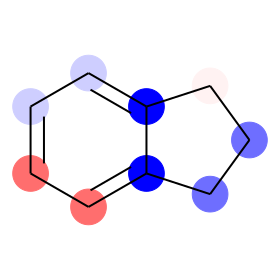

CC(C)Cc1ccccc1
use cuda


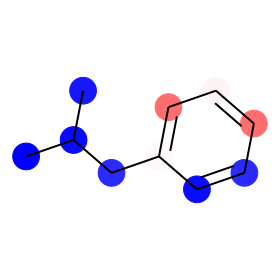

CCCCCCc1ccccc1
use cuda


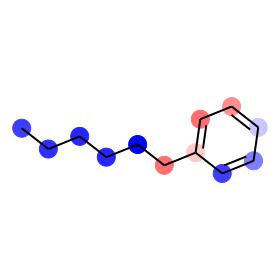

c1ccc(CCc2ccccc2)cc1
use cuda


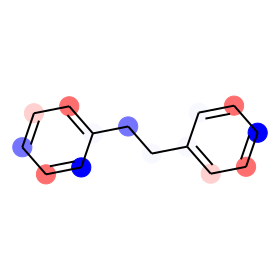

CCc1cccc2ccccc12
use cuda


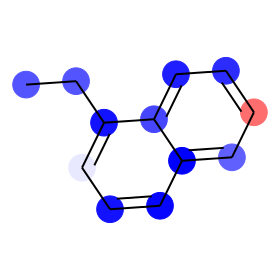

Cc1cc(C)c2ccccc2c1
use cuda


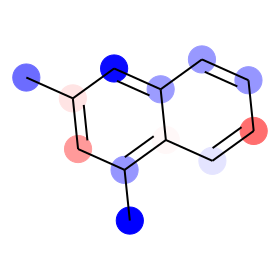

c1ccc2cc3ccccc3cc2c1
use cuda


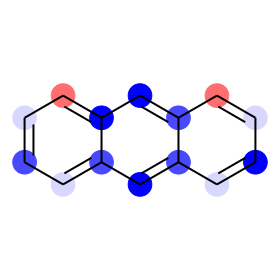

Cc1c2ccccc2c(C)c2ccccc12
use cuda


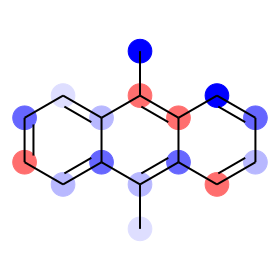

c1ccc2cc3cc4ccccc4cc3cc2c1
use cuda


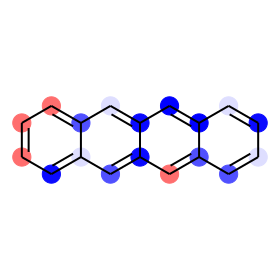

c1ccc2c(c1)ccc1c3ccccc3ccc21
use cuda


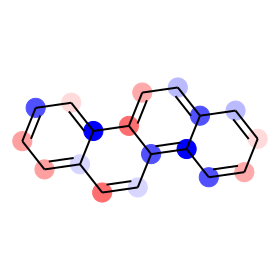

c1ccc2c(c1)ccc1nccnc12
use cuda


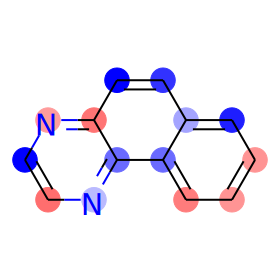

Nc1cc2c3ccccc3ccc2c2ccccc12
use cuda


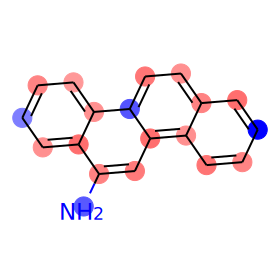

Cc1ccc2cc3c(ccc4ccccc43)c3c2c1CC3
use cuda


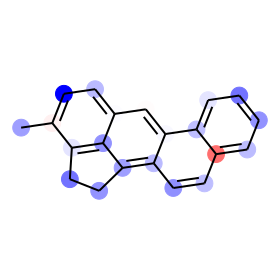

BrCBr
use cuda


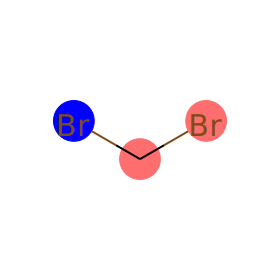

ClC(Cl)(Cl)Cl
use cuda


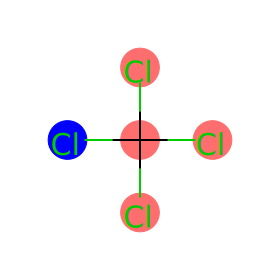

ClCCCl
use cuda


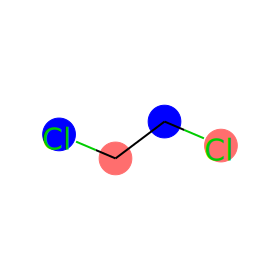

ClC(Cl)C(Cl)Cl
use cuda


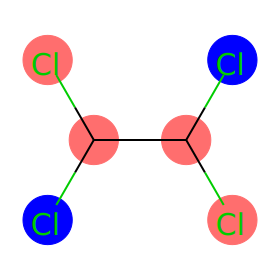

CCCCl
use cuda


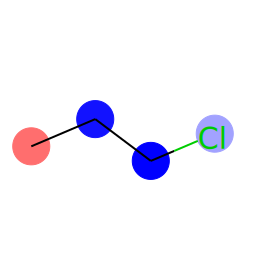

CC(C)I
use cuda


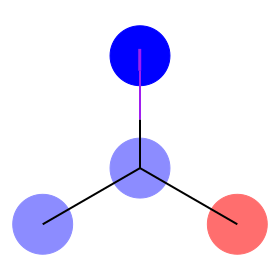

CC(Br)CBr
use cuda


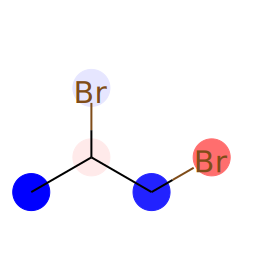

CCCCBr
use cuda


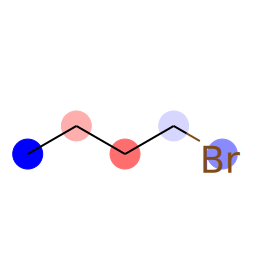

CC(Cl)C(C)Cl
use cuda


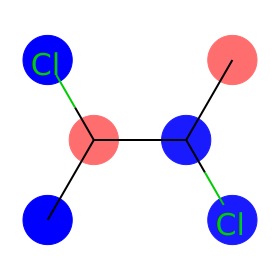

CC(C)CCBr
use cuda


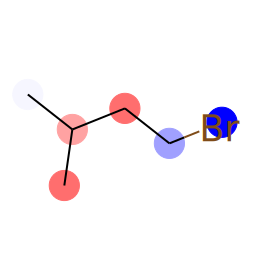

CCCCCCCCBr
use cuda


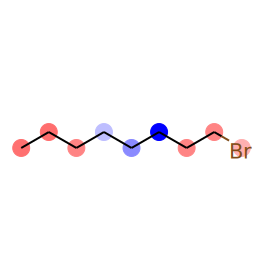

CCCCCCCBr
use cuda


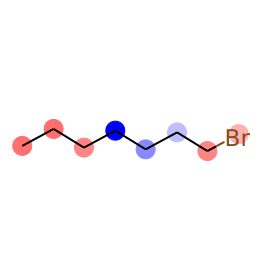

BrC=CBr
use cuda


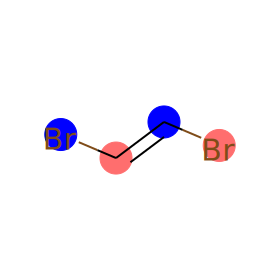

ClC1=C(Cl)C2(Cl)C3C(Cl)C=CC3C1(Cl)C2(Cl)Cl
use cuda


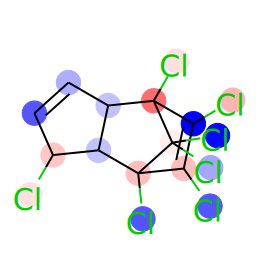

ClC(Cl)=C(Cl)C(Cl)=C(Cl)Cl
use cuda


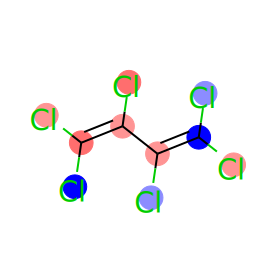

Brc1ccccc1
use cuda


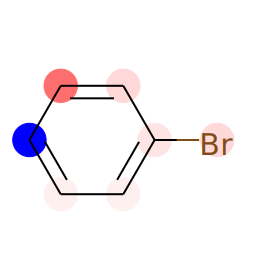

Clc1ccccc1Br
use cuda


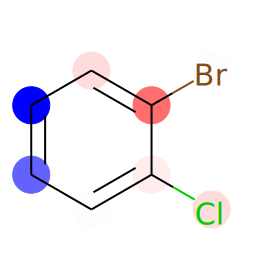

Brc1cccc(Br)c1
use cuda


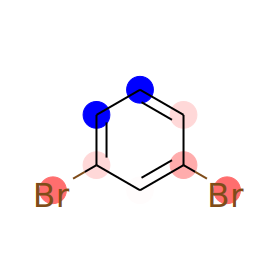

Brc1ccc(Br)c(Br)c1
use cuda


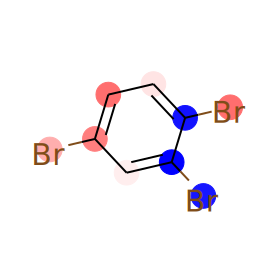

Clc1cc(Cl)c(Cl)c(Cl)c1Cl
use cuda


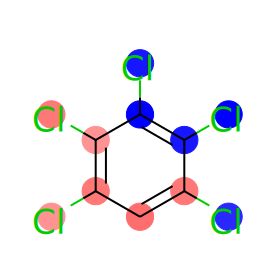

Fc1cccc(F)c1
use cuda


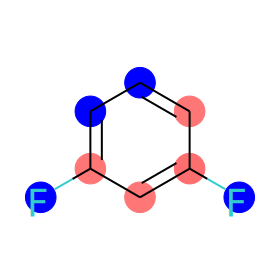

Clc1ccc(-c2ccccc2)cc1
use cuda


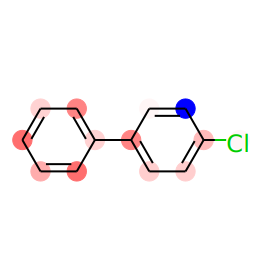

Clc1ccc(-c2ccccc2Cl)cc1
use cuda


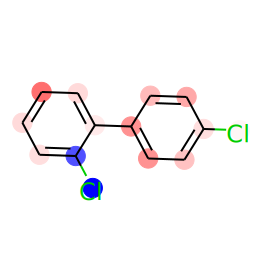

Clc1ccc(Cl)c(-c2ccccc2Cl)c1
use cuda


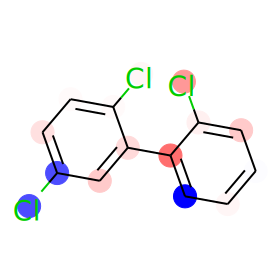

Clc1ccc(-c2ccccc2Cl)cc1Cl
use cuda


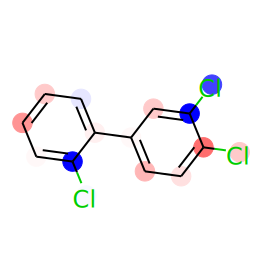

Clc1cc(-c2ccccc2)c(Cl)c(Cl)c1Cl
use cuda


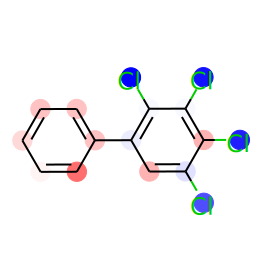

Clc1ccc(Cl)c(-c2c(Cl)cccc2Cl)c1
use cuda


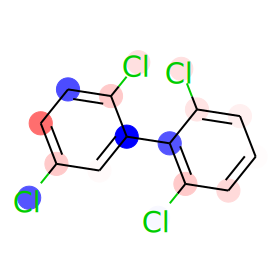

Clc1ccc(Cl)c(-c2ccc(Cl)c(Cl)c2Cl)c1
use cuda


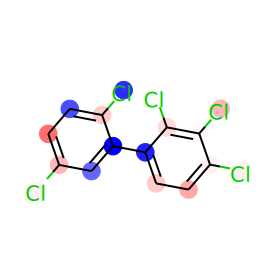

Clc1c(Cl)c(Cl)c(-c2ccccc2)c(Cl)c1Cl
use cuda


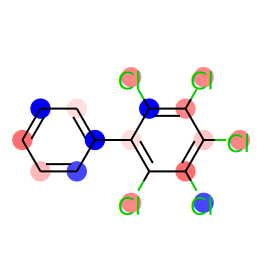

Clc1ccc(Cl)c(-c2cc(Cl)c(Cl)c(Cl)c2Cl)c1
use cuda


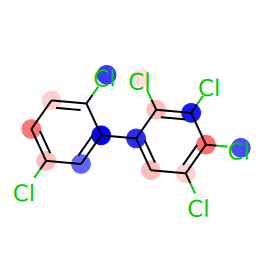

Clc1ccc(-c2ccc(Cl)c(Cl)c2Cl)c(Cl)c1Cl
use cuda


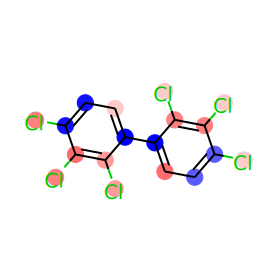

Clc1cc(Cl)c(Cl)c(-c2c(Cl)c(Cl)cc(Cl)c2Cl)c1Cl
use cuda


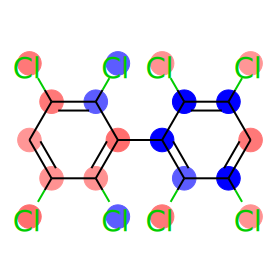

Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)Cl)cc1
use cuda


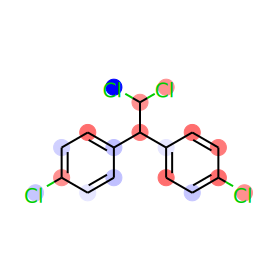

Brc1ccc2ccccc2c1
use cuda


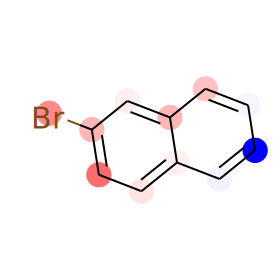

CCCC(C)O
use cuda


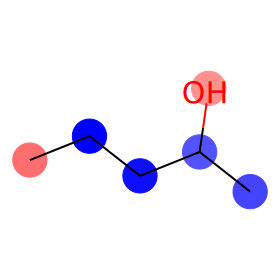

CC(C)(C)CO
use cuda


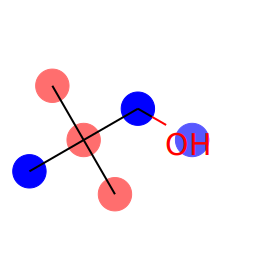

CC(C)C(C)CO
use cuda


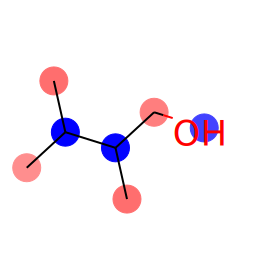

CC(C)CCCO
use cuda


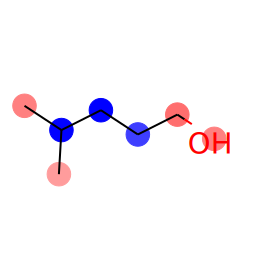

CC(O)C(C)(C)C
use cuda


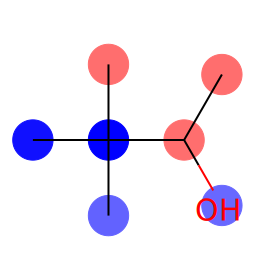

CCCCCC(C)O
use cuda


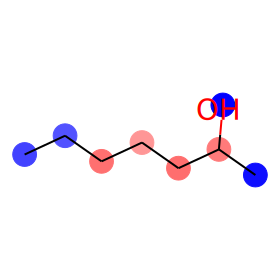

CC(C)CC(C)CO
use cuda


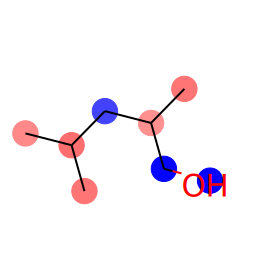

CCC(C)(O)C(C)C
use cuda


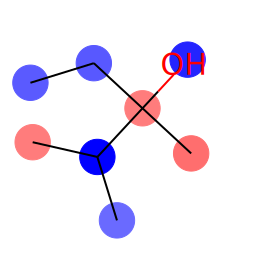

CC(C)(C)C(C)(C)O
use cuda


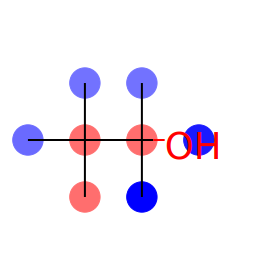

CCCCC(C)(O)CC
use cuda


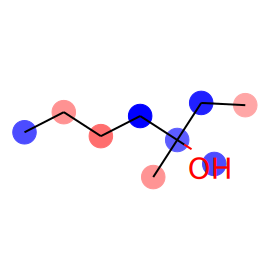

CCCCCCCCCCO
use cuda


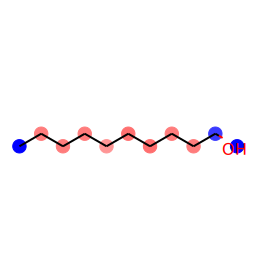

Cc1ccc(CO)cc1
use cuda


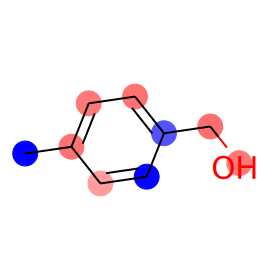

Oc1ccccc1O
use cuda


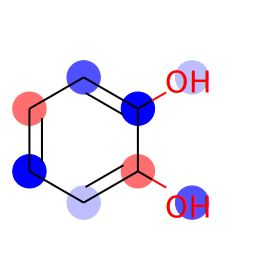

Cc1cccc(O)c1
use cuda


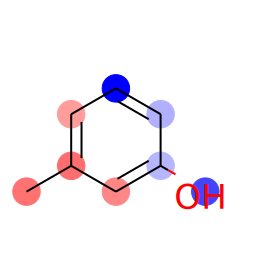

Cc1ccc(C(C)C)c(O)c1
use cuda


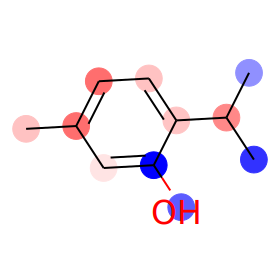

Oc1ccc2ccccc2c1
use cuda


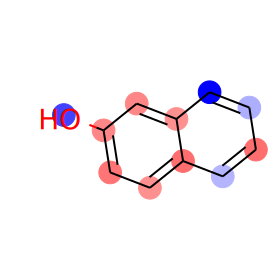

CCCC=O
use cuda


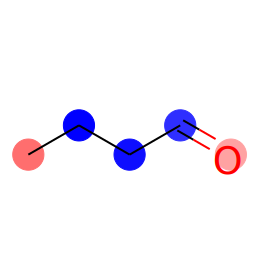

CCCCCCCCC=O
use cuda


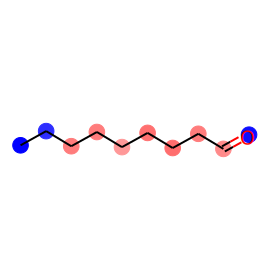

O=Cc1ccco1
use cuda


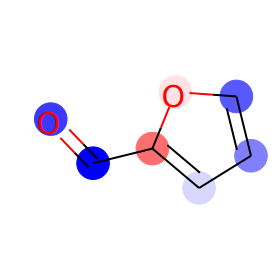

O=C1CCCCC1
use cuda


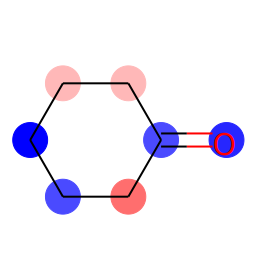

CCCCCCCC(C)=O
use cuda


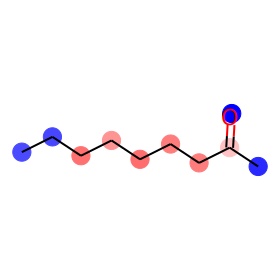

O=C1C=CC(=O)C=C1
use cuda


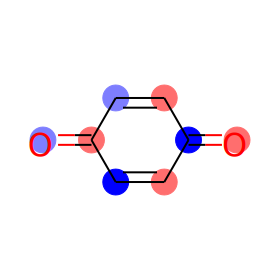

O=C(c1ccccc1)c1ccccc1
use cuda


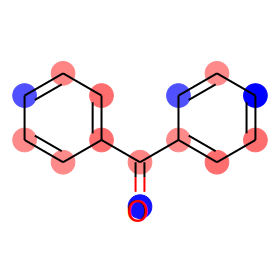

O=C(O)CCC(=O)O
use cuda


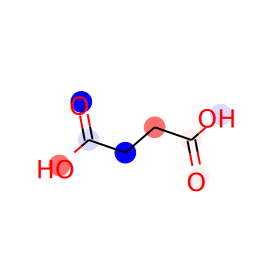

CCCCCCCCCC(=O)O
use cuda


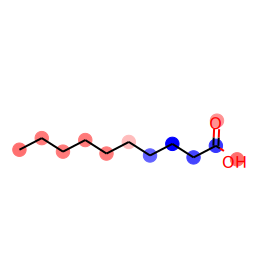

Cc1cccc(C(=O)O)c1
use cuda


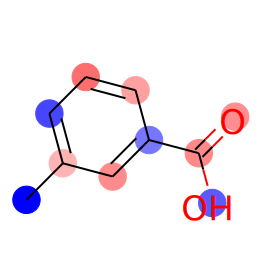

O=C(O)C=Cc1ccccc1
use cuda


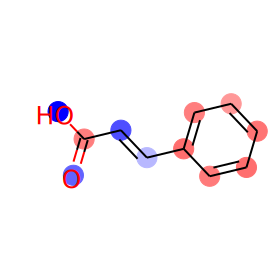

O=C(O)Cc1cccc2ccccc12
use cuda


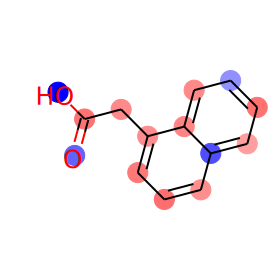

O=C(O)C(c1ccccc1)c1ccccc1
use cuda


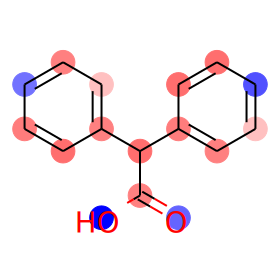

CCCCCCCCCCCCCC(=O)O
use cuda


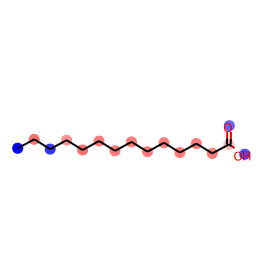

CCOC=O
use cuda


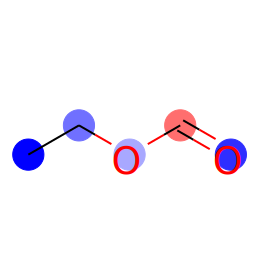

CCOC(=O)CC
use cuda


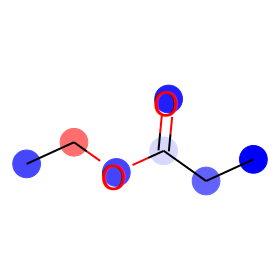

CCCC(=O)OCC
use cuda


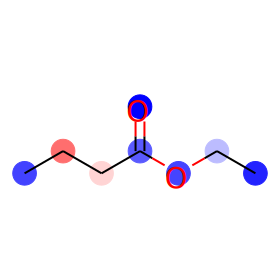

CCCOC(=O)CCC
use cuda


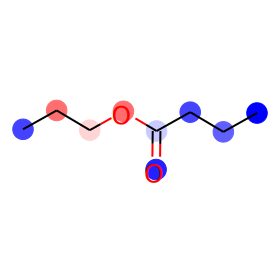

CCCCCC(=O)OCC
use cuda


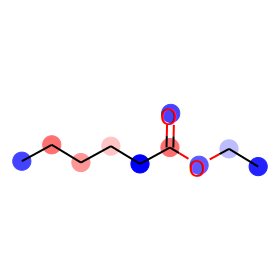

CCCCCCCCC(=O)OCC
use cuda


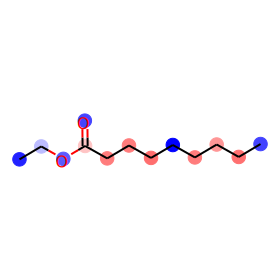

COC(=O)c1ccccc1
use cuda


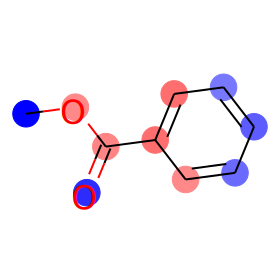

CCCCOC(=O)c1ccccc1C(=O)OCCCC
use cuda


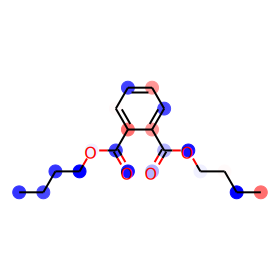

CCOCC
use cuda


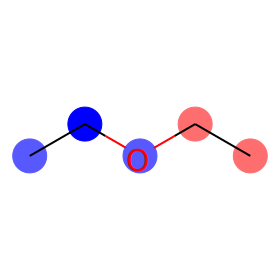

COC(C)(C)C
use cuda


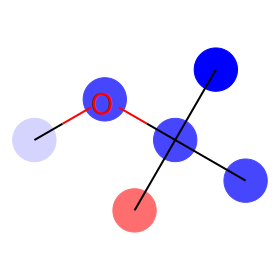

CCCOC(C)C
use cuda


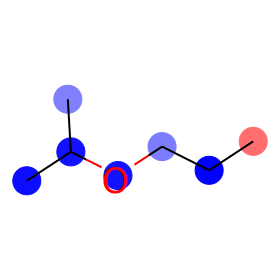

COc1ccccc1
use cuda


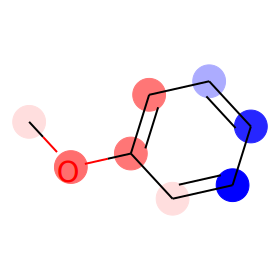

c1ccc(C2CO2)cc1
use cuda


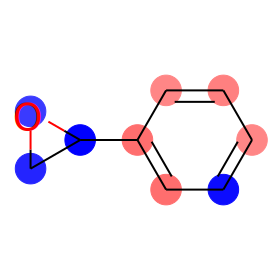

CCCCOCCO
use cuda


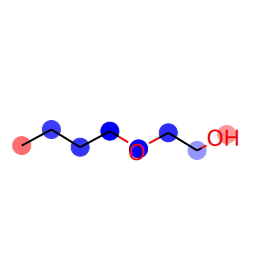

CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO
use cuda


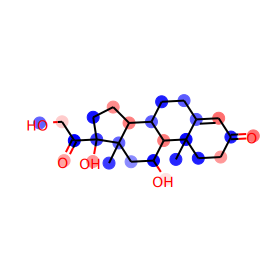

CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)C=CC4(C)C3C(O)CC21C
use cuda


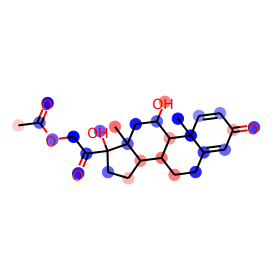

CC12CCC(=O)C=C1CCC1C2CCC2(C)C(C(=O)CO)CCC12
use cuda


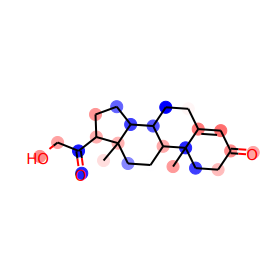

CC12CCC(=O)C=C1CCC1C3CCC(O)(C(=O)CO)C3(C)CC(O)C12F
use cuda


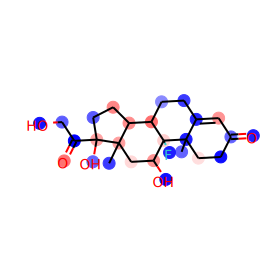

O=C(O)c1ccccc1O
use cuda


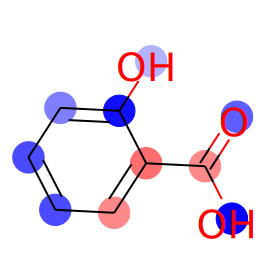

CCOC(=O)c1ccc(O)cc1
use cuda


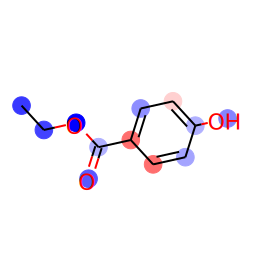

Oc1ccccc1Cl
use cuda


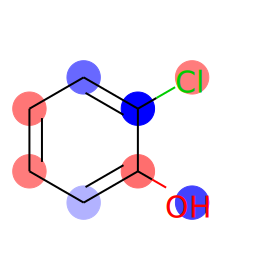

Oc1c(Cl)cc(Cl)cc1Cl
use cuda


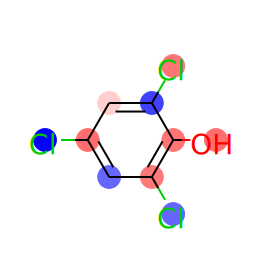

O=C(O)c1ccc(Cl)cc1
use cuda


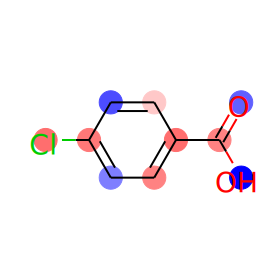

ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl
use cuda


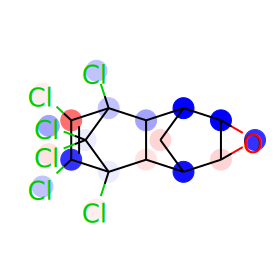

CCCCCCN
use cuda


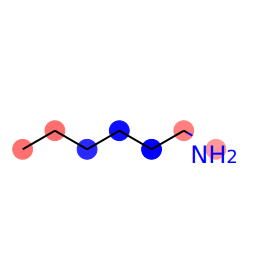

CCCCCCCCN
use cuda


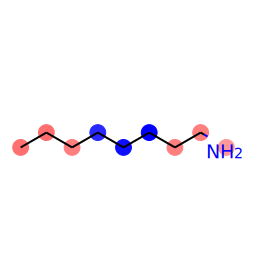

CNc1ccccc1
use cuda


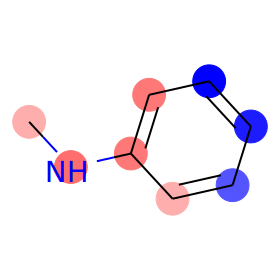

CN(C)c1ccccc1
use cuda


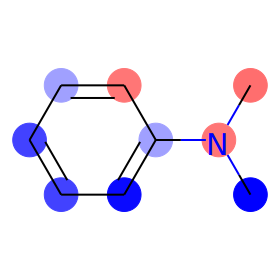

Nc1cccc2ccccc12
use cuda


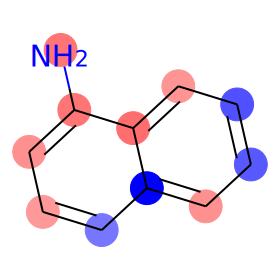

Cc1ccc(C)nc1
use cuda


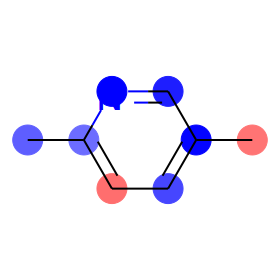

c1ccc2cnccc2c1
use cuda


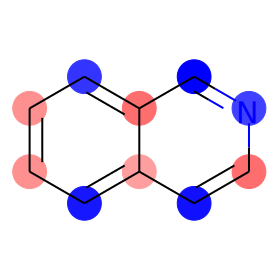

O=C(O)c1cccnc1
use cuda


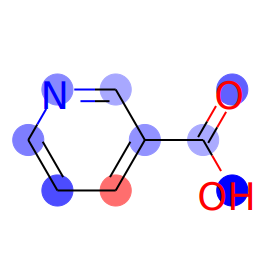

Cc1cc(N)nc(C)n1
use cuda


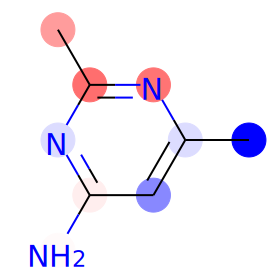

c1cc[nH]c1
use cuda


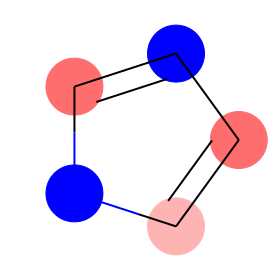

Sc1nc2ccccc2s1
use cuda


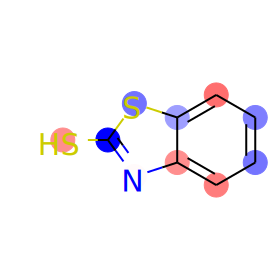

Oc1ccc2ncccc2c1
use cuda


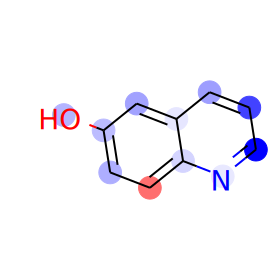

CCC1(CC)C(=O)NC(=O)N(C)C1=O
use cuda


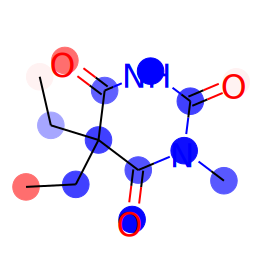

CN1C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2
use cuda


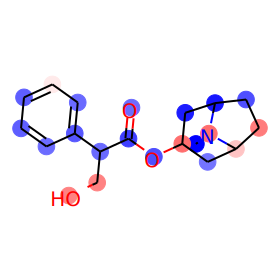

NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl
use cuda


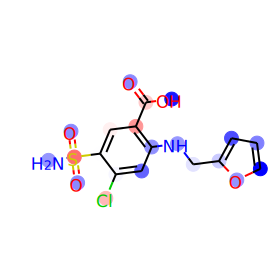

CCC1(CCC(C)C)C(=O)NC(=O)NC1=O
use cuda


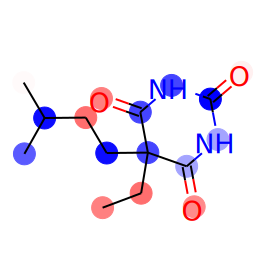

OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1
use cuda


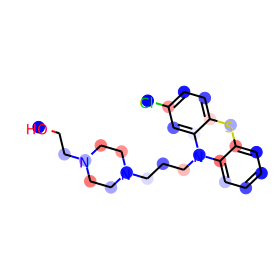

CC(=O)Nc1nnc(S(N)(=O)=O)s1
use cuda


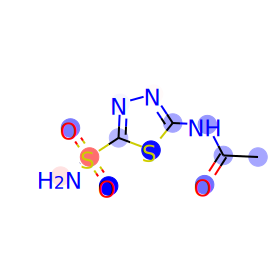

COC(=O)C1=CCCN(C)C1
use cuda


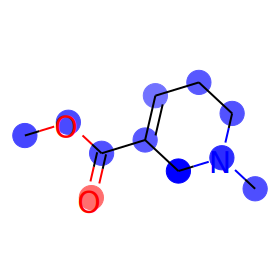

CCC1(C(C)C)C(=O)NC(=O)NC1=O
use cuda


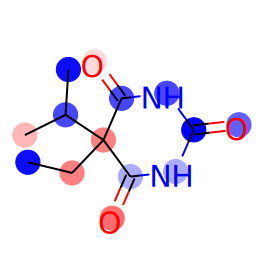

COc1ccc(NS(=O)(=O)c2ccc(N)cc2)nn1
use cuda


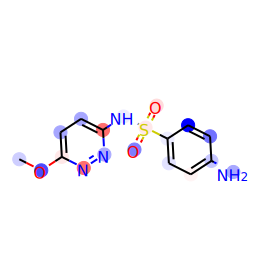

CCN(CC)C(=S)SSC(=S)N(CC)CC
use cuda


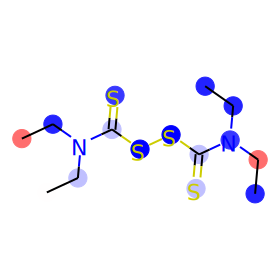

COC1=CC(=O)CC(C)C12Oc1c(Cl)c(OC)cc(OC)c1C2=O
use cuda


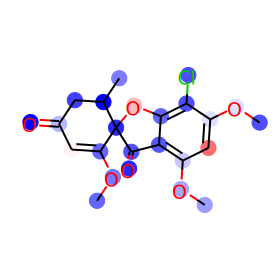

Cc1nnc(NS(=O)(=O)c2ccc(N)cc2)s1
use cuda


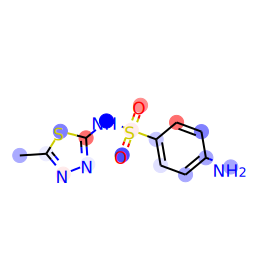

COc1cc2c(cc1OC)C13CCN4CC5=CCOC6CC(=O)N2C1C6C5CC43
use cuda


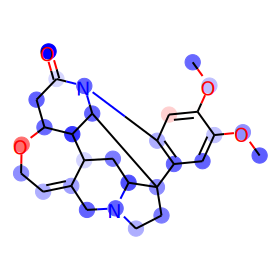

Nc1ccc(S(=O)(=O)Nc2ccnn2-c2ccccc2)cc1
use cuda


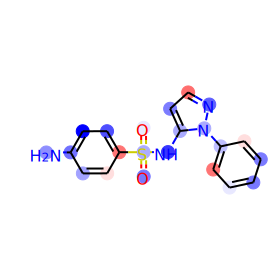

Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1
use cuda


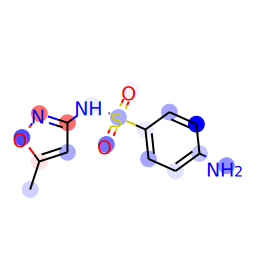

COc1cc(NS(=O)(=O)c2ccc(N)cc2)nc(C)n1
use cuda


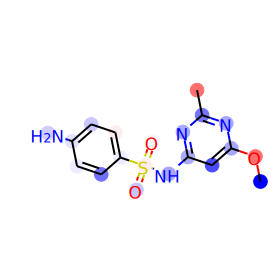

CC1=C(C(=O)Nc2ccccc2)S(=O)(=O)CCO1
use cuda


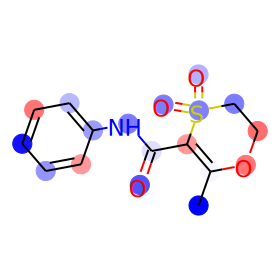

CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1
use cuda


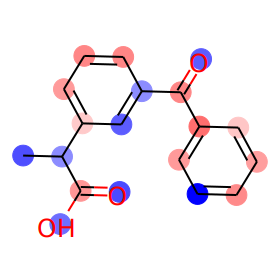

CNC(=NC#N)NCCSCc1[nH]cnc1C
use cuda


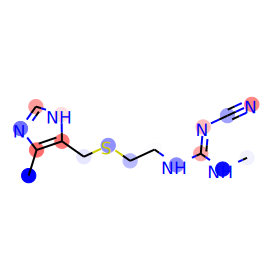

Cn1c(=O)c2c(ncn2C)n(C)c1=O
use cuda


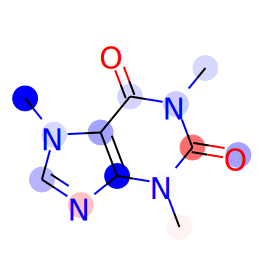

CC1CC(C)C(=O)C(C(O)CC2CC(=O)NC(=O)C2)C1
use cuda


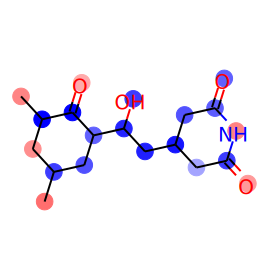

C1CNCCN1
use cuda


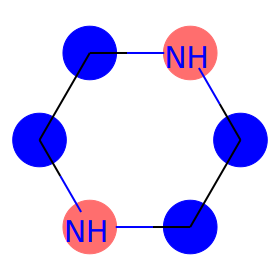

O=C1CNC(=O)N1
use cuda


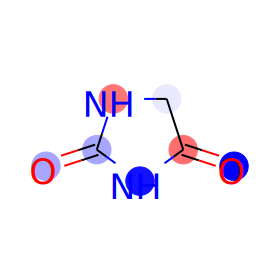

CN1CCCC1=O
use cuda


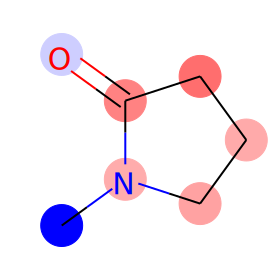

Nc1ccccc1O
use cuda


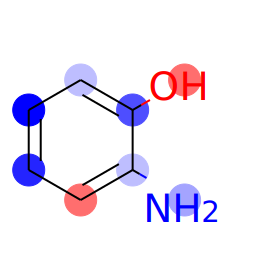

CCOC(N)=O
use cuda


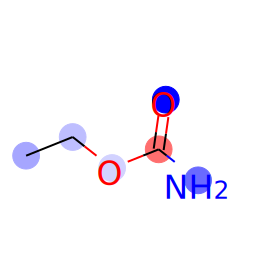

CNC(=O)Oc1cccc2ccccc12
use cuda


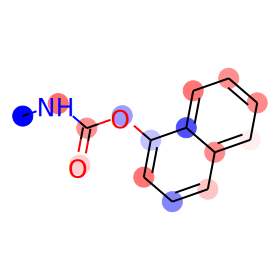

CNC(N)=O
use cuda


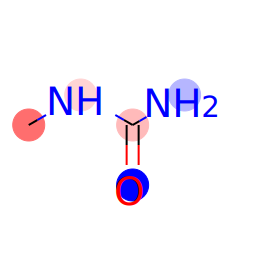

C=CC(N)=O
use cuda


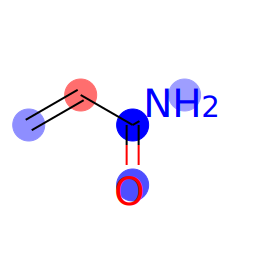

CC(=O)Nc1ccc(O)cc1
use cuda


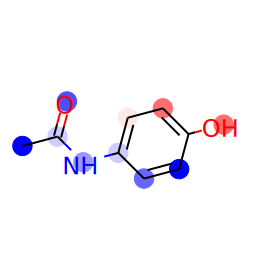

CC(C)[N+](=O)[O-]
use cuda


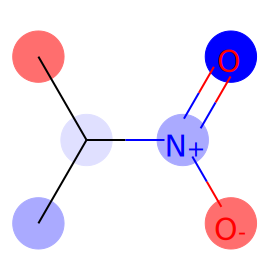

O=[N+]([O-])c1cccc2ccccc12
use cuda


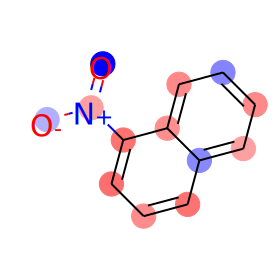

O=C(O)c1ccc([N+](=O)[O-])cc1
use cuda


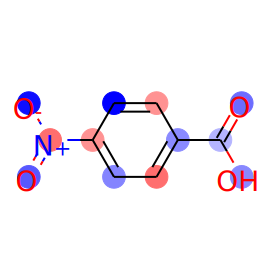

Nc1ccccc1[N+](=O)[O-]
use cuda


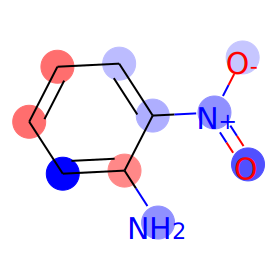

Nc1cccc(Cl)c1
use cuda


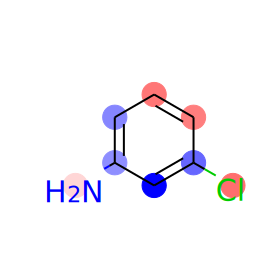

N#Cc1c(Cl)c(Cl)c(Cl)c(C#N)c1Cl
use cuda


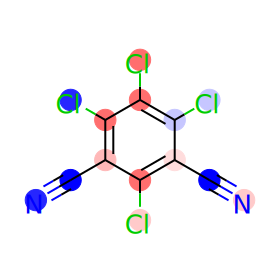

Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1
use cuda


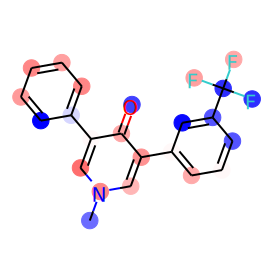

CCC(=O)Nc1ccc(Cl)c(Cl)c1
use cuda


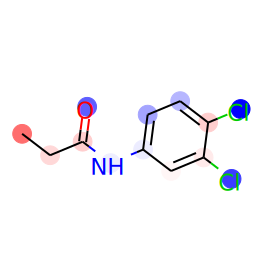

CCc1cccc(CC)c1N(COC)C(=O)CCl
use cuda


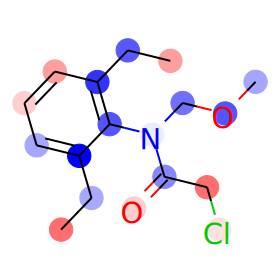

CCS
use cuda


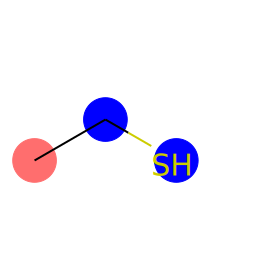

NC(N)=S
use cuda


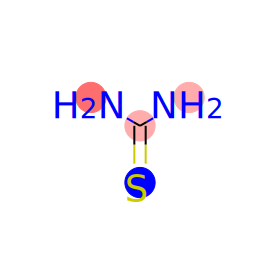

COC(=O)NS(=O)(=O)c1ccc(N)cc1
use cuda


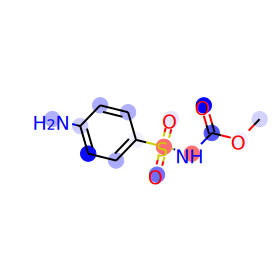

COP(=O)(OC)C(O)C(Cl)(Cl)Cl
use cuda


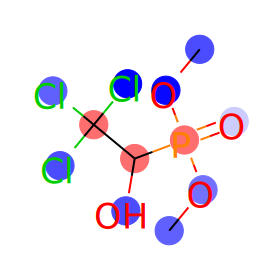

COP(=S)(OC)Oc1ccc(SC)c(C)c1
use cuda


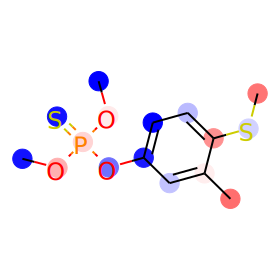

COP(=S)(OC)Oc1ccc([N+](=O)[O-])c(C)c1
use cuda


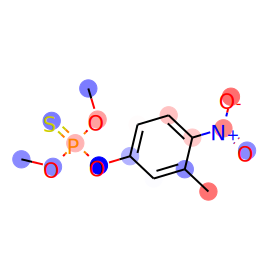

COP(=S)(OC)Oc1cc(Cl)c(I)cc1Cl
use cuda


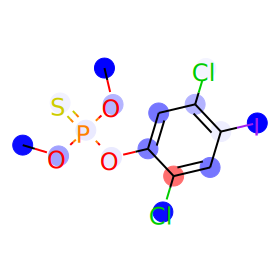

CC(CCC(=O)O)C1CCC2C3C(O)C(O)C4CC(O)CCC4(C)C3CCC12C
use cuda


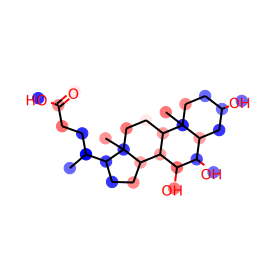

CC1CNCCN1
use cuda


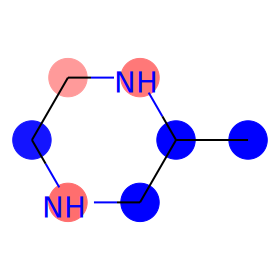

CC(=O)Nc1ccc(Cl)cc1
use cuda


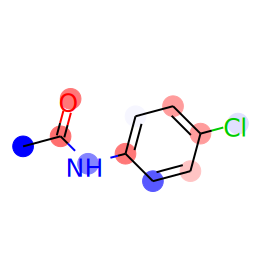

CC(=O)Nc1ccc([N+](=O)[O-])cc1
use cuda


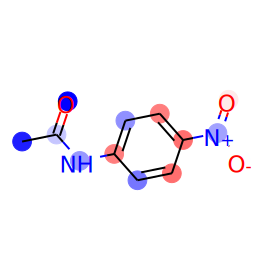

COc1ccc2c(c1OC)C(=O)OC2C1c2cc3c(cc2CCN1C)OCO3
use cuda


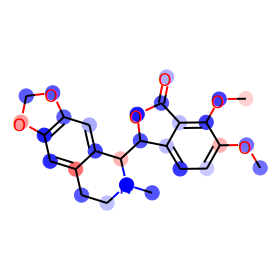

O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1
use cuda


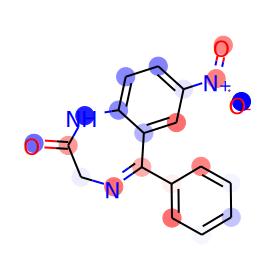

Oc1ccc(Cl)cc1Cc1cc(Cl)ccc1O
use cuda


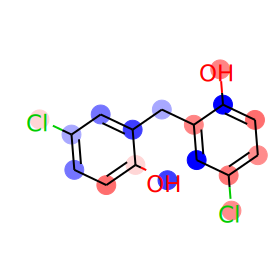

Nc1c(Cl)c(Cl)nc(C(=O)O)c1Cl
use cuda


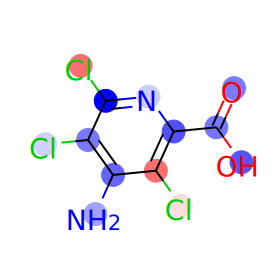

NC(Cc1ccc(O)cc1)C(=O)O
use cuda


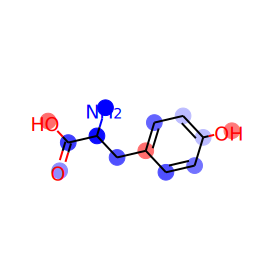

CC(C)N(C(=O)SCC(Cl)=CCl)C(C)C
use cuda


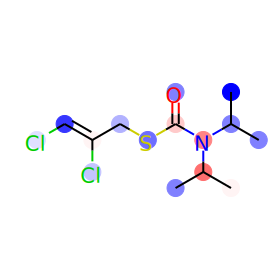

CCCCOC(=O)c1ccc(O)cc1
use cuda


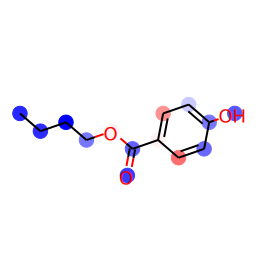

CCCOC(=O)c1cc(O)c(O)c(O)c1
use cuda


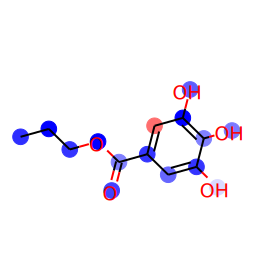

CCCCCOC(=O)c1ccc(N)cc1
use cuda


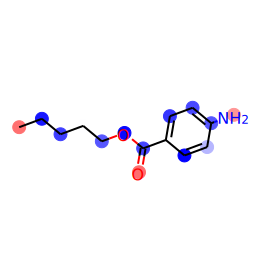

c1ccc(-c2ccc(-c3ccccc3)cc2)cc1
use cuda


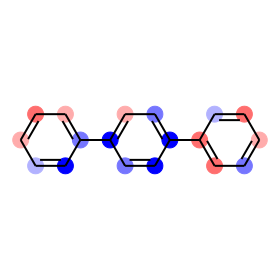

CC(=O)Nc1ccccc1Cl
use cuda


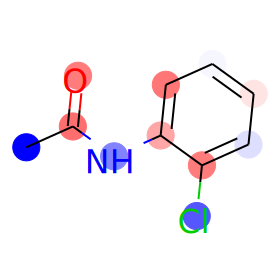

CCC1CCCCN1
use cuda


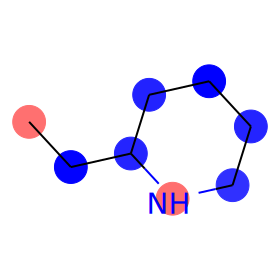

C=CCc1ccc(OC)cc1
use cuda


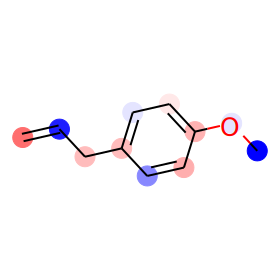

COc1c(O)c(Cl)c(Cl)c(Cl)c1Cl
use cuda


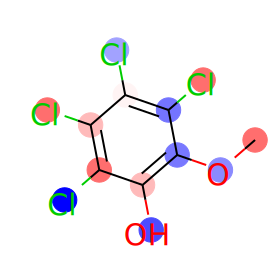

O=C1CSC(=S)N1
use cuda


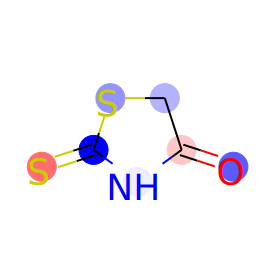

Ic1[nH]c(I)c(I)c1I
use cuda


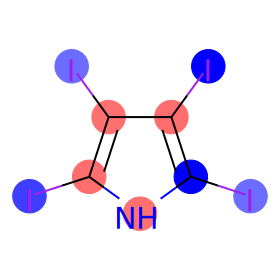

Nc1cc[nH]c(=O)n1
use cuda


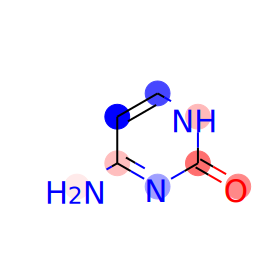

NC(=O)CC(N)C(=O)O
use cuda


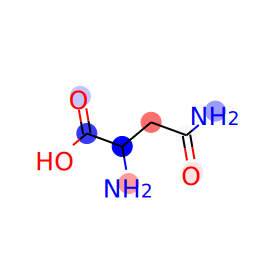

CCS(=O)(=O)CC
use cuda


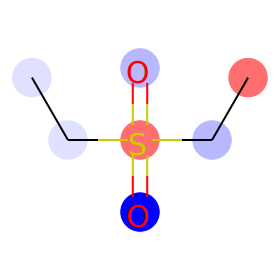

Oc1ccncc1
use cuda


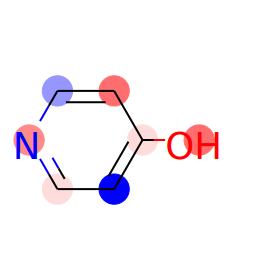

Cc1cc(=O)[nH]c(=O)[nH]1
use cuda


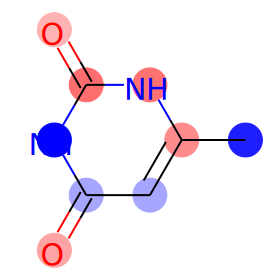

OC1COC(O)C(O)C1O
use cuda


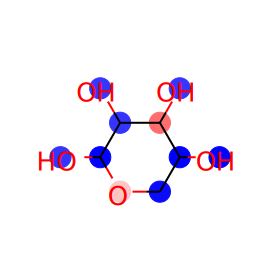

Sc1ncnc2nccnc12
use cuda


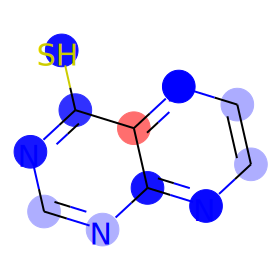

NS(=O)(=O)c1ccccc1
use cuda


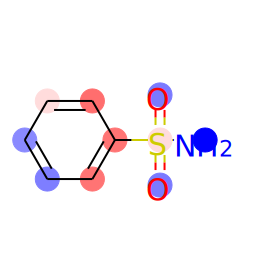

CN(C)C(=S)SSC(=S)N(C)C
use cuda


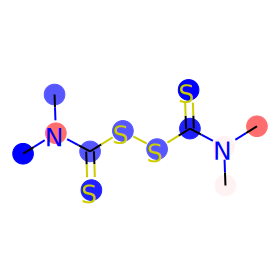

CC1CNC(C)CN1
use cuda


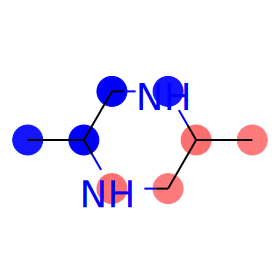

O=C(O)c1cccc(I)c1
use cuda


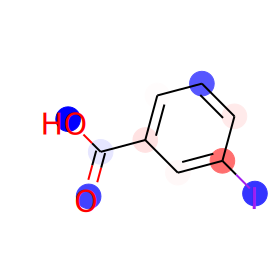

COc1ncnc2nccnc12
use cuda


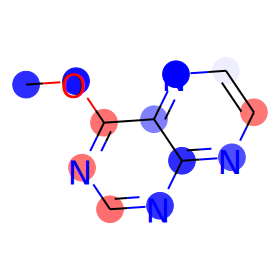

CSc1cnc2ncncc2n1
use cuda


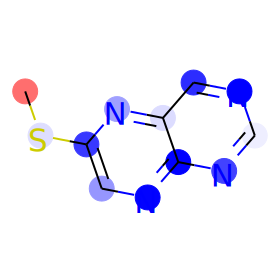

CCCc1cc(=O)[nH]c(=S)[nH]1
use cuda


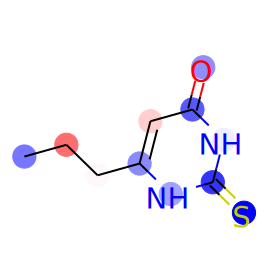

Clc1c(Cl)c(Cl)c2nccnc2c1Cl
use cuda


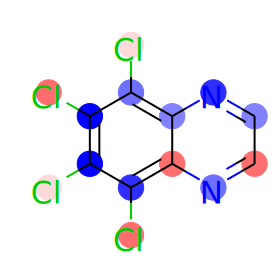

O=C(O)COc1ccc(Cl)cc1Cl
use cuda


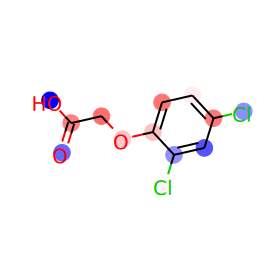

COC(=O)c1ccccc1O
use cuda


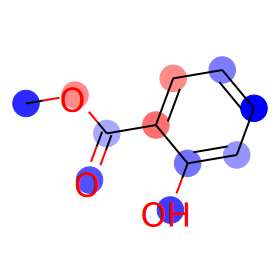

CNc1ccccc1C(=O)O
use cuda


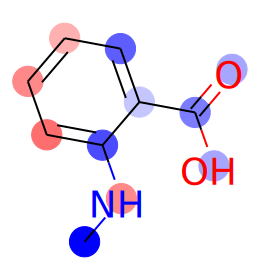

CCOc1ccccc1
use cuda


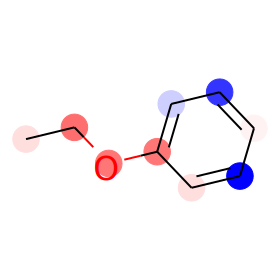

NCCc1ccc(O)cc1
use cuda


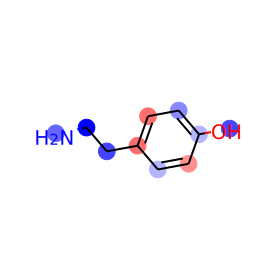

CC(=O)CC(=O)CC(C)C
use cuda


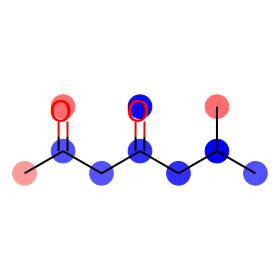

CC1CCCCC1C
use cuda


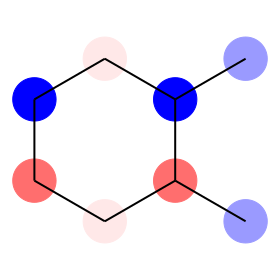

O=C(O)Cn1c(=O)sc2cccc(Cl)c21
use cuda


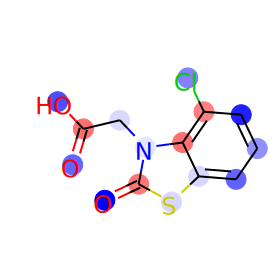

CC(Oc1cccc(Cl)c1)C(=O)O
use cuda


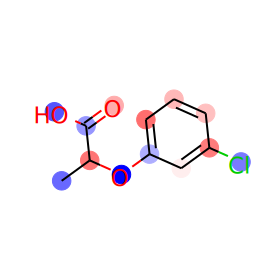

COC(=O)c1ccc(OC)cc1
use cuda


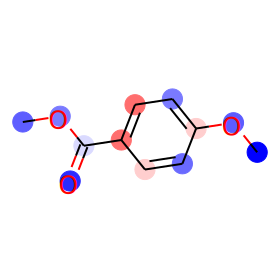

CCOc1ccc(NC(N)=O)cc1
use cuda


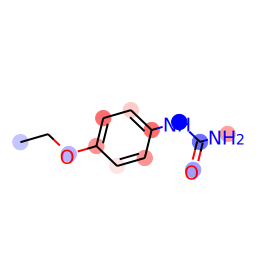

CCCCCCCCC(=O)O
use cuda


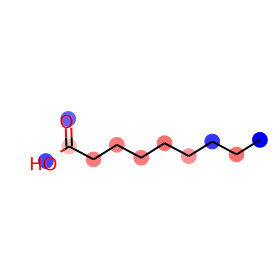

Nc1cnn(-c2ccccc2)c(=O)c1Cl
use cuda


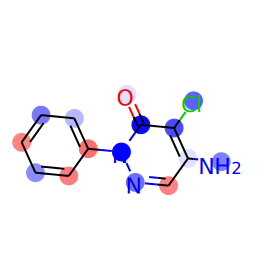

Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1
use cuda


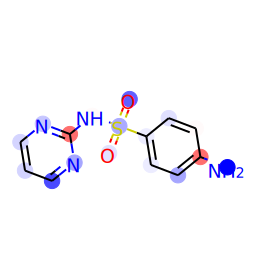

CC(=O)Nc1ccc(OC(C)=O)cc1
use cuda


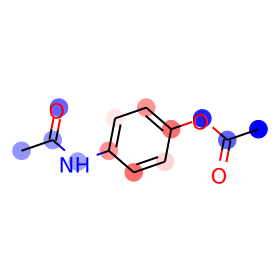

Oc1ccc2c(c1)CCCC2
use cuda


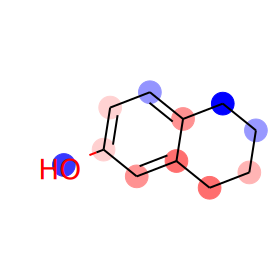

Cc1ccc(C(C)C)cc1O
use cuda


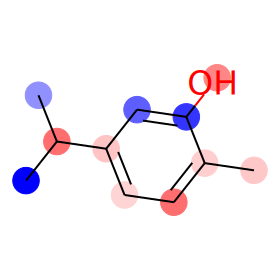

CC12CCC(C1)C(C)(C)C2=O
use cuda


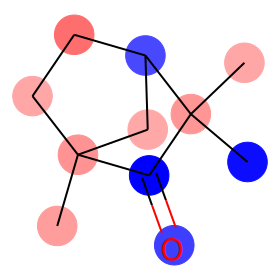

CC1CCC(C(C)C)C(=O)C1
use cuda


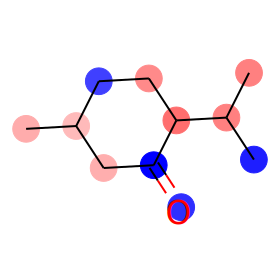

Cc1cc(C)c2ccccc2n1
use cuda


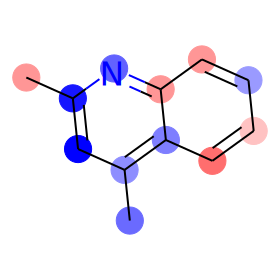

CCN(CC)c1c([N+](=O)[O-])cc(C(F)(F)F)c(N)c1[N+](=O)[O-]
use cuda


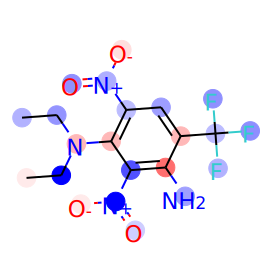

COC(=O)C1C2C=CC(C2)C1C(=O)OC
use cuda


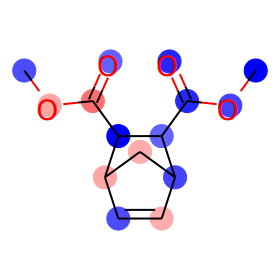

CCCCNC(=O)NS(=O)(=O)c1ccccc1
use cuda


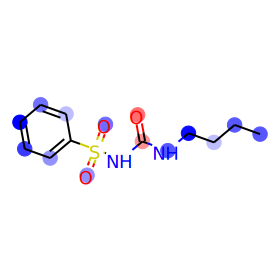

CCCCc1c(C)nc(NCC)nc1O
use cuda


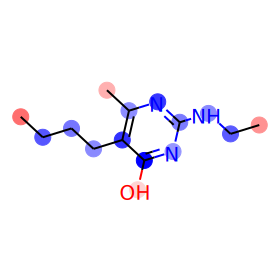

O=C1C(Cl)=C(NC(=O)C(Cl)Cl)C(=O)c2ccccc21
use cuda


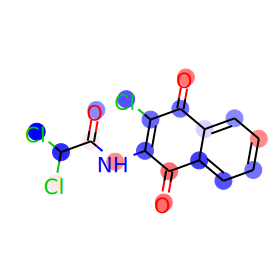

O=C1C=CC(O)(c2cc(O)ccc2O)C=C1
use cuda


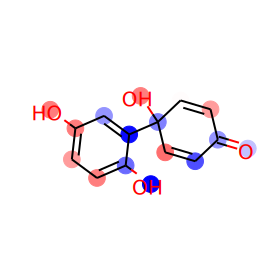

CCC(N)Cc1c[nH]c2ccccc12
use cuda


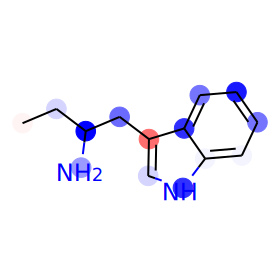

CCCCCCc1ccc(O)cc1O
use cuda


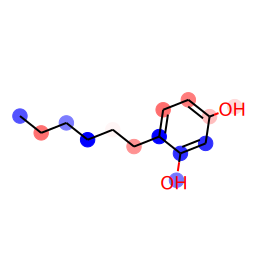

O=C(Nc1ccccc1)c1ccccc1I
use cuda


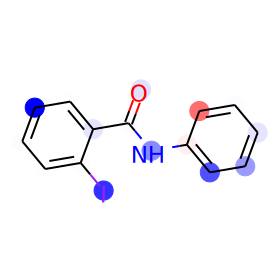

CCCCN(CC)c1c([N+](=O)[O-])cc(C(F)(F)F)cc1[N+](=O)[O-]
use cuda


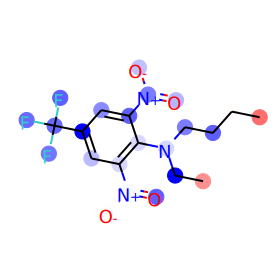

CCCCc1c(C)nc(NCC)nc1OS(=O)(=O)N(C)C
use cuda


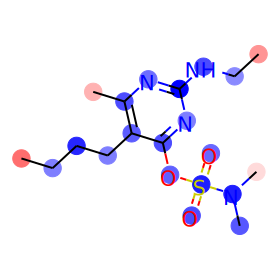

Clc1ccc(C(c2ccccc2Cl)C(Cl)(Cl)Cl)cc1
use cuda


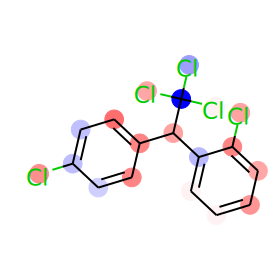

O=C(O)c1ccccc1-c1ccccc1C(=O)O
use cuda


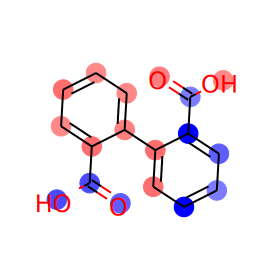

O=C(Oc1ccccc1)c1ccccc1
use cuda


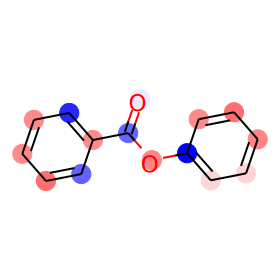

CC(C)(C)C(=O)C1C(=O)c2ccccc2C1=O
use cuda


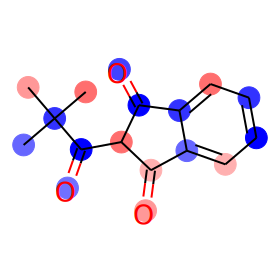

CN(C)CCN(Cc1cccs1)c1ccccn1
use cuda


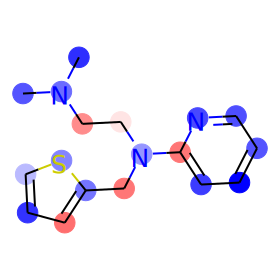

O=c1c(O)c(-c2ccc(O)cc2O)oc2cc(O)cc(O)c12
use cuda


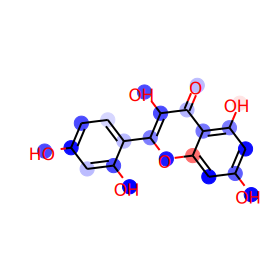

NS(=O)(=O)c1cc2c(cc1C(F)(F)F)NC(Cc1ccccc1)NS2(=O)=O
use cuda


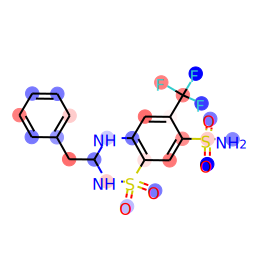

CC(C)Oc1cc(-n2nc(C(C)(C)C)oc2=O)c(Cl)cc1Cl
use cuda


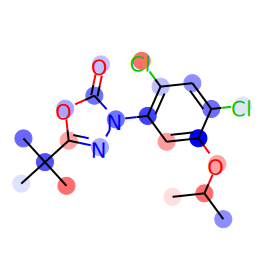

CCc1cccc(C)c1N(C(=O)CCl)C(C)COC
use cuda


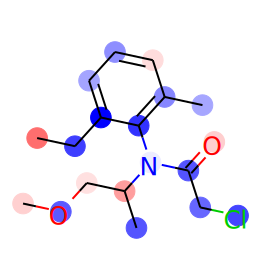

O=C1C=C2CC3(O)COc4c(ccc(O)c4O)C3=C2C=C1O
use cuda


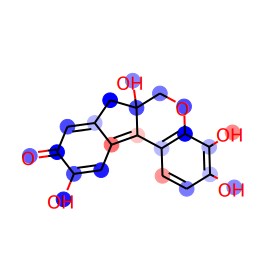

OC(c1ccc(Cl)cc1)(c1cncnc1)c1ccccc1Cl
use cuda


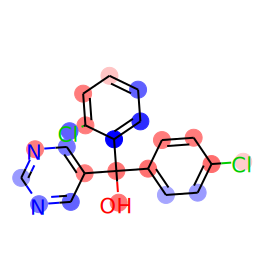

c1ccc(CN(CC2=NCCN2)c2ccccc2)cc1
use cuda


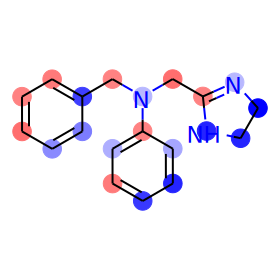

C=CC(c1ccc(O)cc1)C(C=C)c1ccc(O)cc1
use cuda


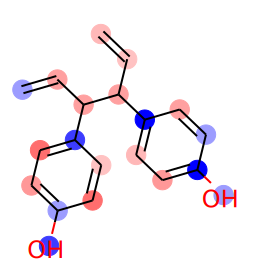

CCC(c1ccc(O)cc1)C(CC)c1ccc(O)cc1
use cuda


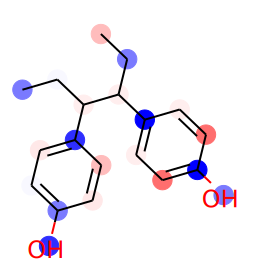

CCC1CN2CCC1CC2C(O)c1ccnc2ccccc12
use cuda


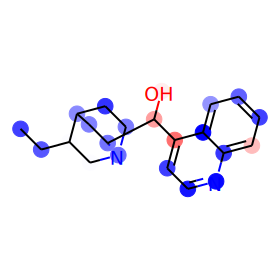

CC12CCC3C(CCC4CC5SC5CC43C)C1CCC2O
use cuda


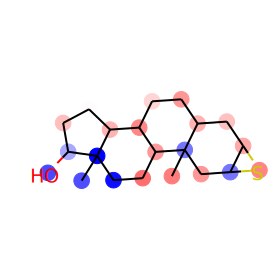

CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1
use cuda


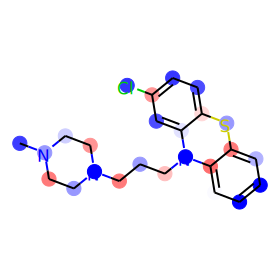

CC(C)C1=CC2=CCC3C(C)(C(=O)O)CCCC3(C)C2CC1
use cuda


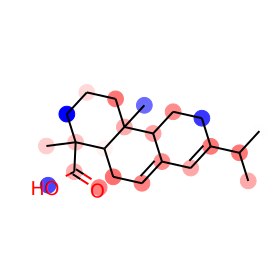

C#CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C
use cuda


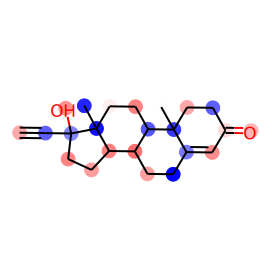

CCOC(=O)C(c1c(O)c2ccccc2oc1=O)c1c(O)c2ccccc2oc1=O
use cuda


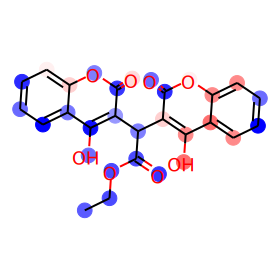

NCCC(O)C(=O)NC1CC(N)C(OC2OC(CN)C(O)C(O)C2O)C(O)C1OC1OC(CO)C(O)C(N)C1O
use cuda


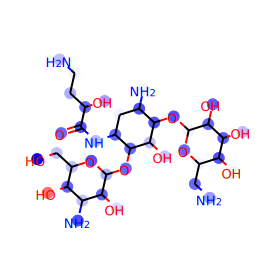

COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1
use cuda


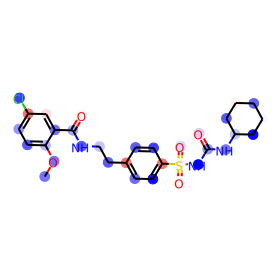

CC1CCC2(OC1)OC1CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)C1C2C
use cuda


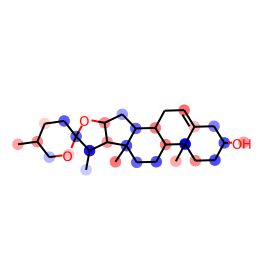

In [32]:
for i in range(len(target)):
    mol, aw, svg = drawmol(i, target, 0)
    display(SVG(svg))

In [33]:
from rdkit.Chem import Draw

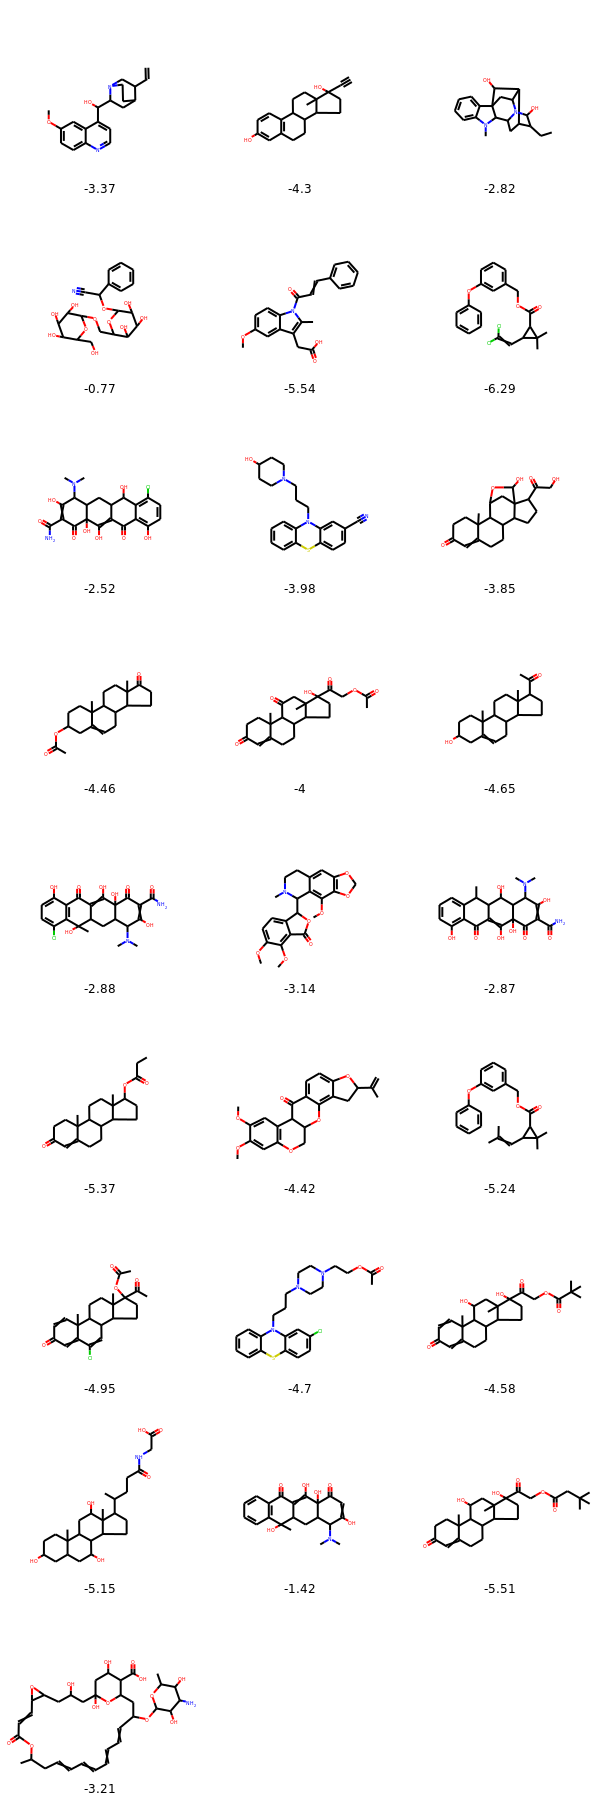

In [40]:
ms = [mol for mol in train_mols]
Draw.MolsToGridImage(ms[1000:1050], legends=[m.GetProp('SOL') for m in ms[1000:1050]])